# Drought Analysis in Sri Lanka

This notebook guides you through:

1. Fetching adm boundaries.
2. Fetching timeseries climate data (SPI).
3. Identifying number of extreme drought days.
4. Plotting and mapping the results.

In [2]:
import pandas as pd
import geopandas as gpd
from shapely import from_geojson
import matplotlib.pyplot as plt # pip install matplotlib contextily
import contextily as ctx
from space2stats_client import Space2StatsClient
import requests
import json
import h3


## Fetch ADM Boundaries

Text(0.5, 1.0, 'Sri Lanka ADM2 Regions')

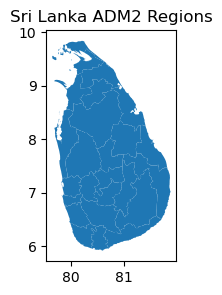

In [32]:
# Set up the client and fetch ADM2 boundaries for Sri Lanka
client = Space2StatsClient()
ISO3 = "LKA"  # Sri Lanka 
ADM = "ADM2"  # Level 2 administrative boundaries
adm2_boundaries = client.fetch_admin_boundaries(ISO3, ADM)

# Display the ADM2 regions
print(f"Retrieved {len(adm2_boundaries)} ADM2 regions")
adm2_boundaries.plot(figsize=(3, 3))
plt.title("Sri Lanka ADM2 Regions")


In [10]:
# Define the fields and parameters
fields = ["spi"]
all_adm2_data = []

# Loop through each ADM2 region to fetch its data
for idx, adm2_feature in adm2_boundaries.iterrows():
    # Convert the geometry to GeoJSON
    adm2_geojson = json.loads(adm2_boundaries.iloc[[idx]].to_json())
    feature = adm2_geojson['features'][0]
    
    payload = {
        "aoi": feature,
        "spatial_join_method": "centroid",
        "fields": fields,
        "start_date": "2019-01-01",
        "geometry": "polygon"
    }
    
    response = requests.post(f"{BASE_URL}/timeseries", json=payload)
    
    if response.status_code == 200:
        region_data = response.json()
        region_name = adm2_feature['shapeName']
        for record in region_data:
            record['region'] = region_name
        all_adm2_data.extend(region_data)
        print(f"Retrieved data for {region_name}")
    else:
        print(f"Error retrieving data for region {adm2_feature['NAME_2']}: {response.text}")

Retrieved data for Jaffna District
Retrieved data for Kilinochchi District
Retrieved data for Mannar District
Retrieved data for Mullaitivu District
Retrieved data for Vavuniya District
Retrieved data for Galle District
Retrieved data for Hambantota District
Retrieved data for Matara District
Retrieved data for Ampara District
Retrieved data for Anuradhapura District
Retrieved data for Badulla District
Retrieved data for Batticaloa District
Retrieved data for Monaragala District
Retrieved data for Polonnaruwa District
Retrieved data for Colombo District
Retrieved data for Gampaha District
Retrieved data for Kalutara District
Retrieved data for Kegalle District
Retrieved data for Kurunegala District
Retrieved data for Puttalam District
Retrieved data for Ratnapura District
Retrieved data for Kandy District
Retrieved data for Matale District
Retrieved data for Nuwara Eliya District
Retrieved data for Trincomalee District


## Calculate the number of extreme drought events

In [12]:
# Convert response data to a pandas dataframe
df = pd.DataFrame(all_adm2_data)

# Convert date strings to datetime objects
if 'date' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year

# Set an extereme drought threshold
drought_threshold = -2

# Create a binary column indicating extreme drought days
df['extreme_drought'] = (df['spi'] <= drought_threshold).astype(int)

# Group by region and year, then count extreme drought days
yearly_drought = df.groupby(['region', 'year'])['extreme_drought'].sum().reset_index()

# Pivot the table to have years as columns
drought_pivot = yearly_drought.pivot(index='region', columns='year', values='extreme_drought')

# Rename columns for clarity
drought_pivot.columns = [f'{year}' for year in drought_pivot.columns]

# Add total drought days column
drought_pivot['Total Drought Days'] = drought_pivot.sum(axis=1)

# Sort by total drought days in descending order
drought_pivot = drought_pivot.sort_values('Total Drought Days', ascending=False)

# Reset index to make 'region' a regular column
result_table = drought_pivot.reset_index().rename(columns={'region': 'District'})

# Display the resulting table
display(result_table)


,District,2019,2020,2021,2022,2023,2024,Total Drought Days
0,Nuwara Eliya District,0,0,0,0,0,78,78
1,Kandy District,0,0,0,0,0,69,69
2,Badulla District,0,0,0,0,0,52,52
3,Matale District,0,0,0,0,0,45,45
4,Kurunegala District,16,0,0,0,0,18,34
5,Jaffna District,25,0,0,0,0,0,25
6,Monaragala District,0,0,0,0,0,24,24
7,Ratnapura District,0,0,0,0,0,22,22
8,Mullaitivu District,0,14,0,0,0,6,20
9,Kegalle District,9,0,0,0,0,11,20


## Plot the number of extreme drought events

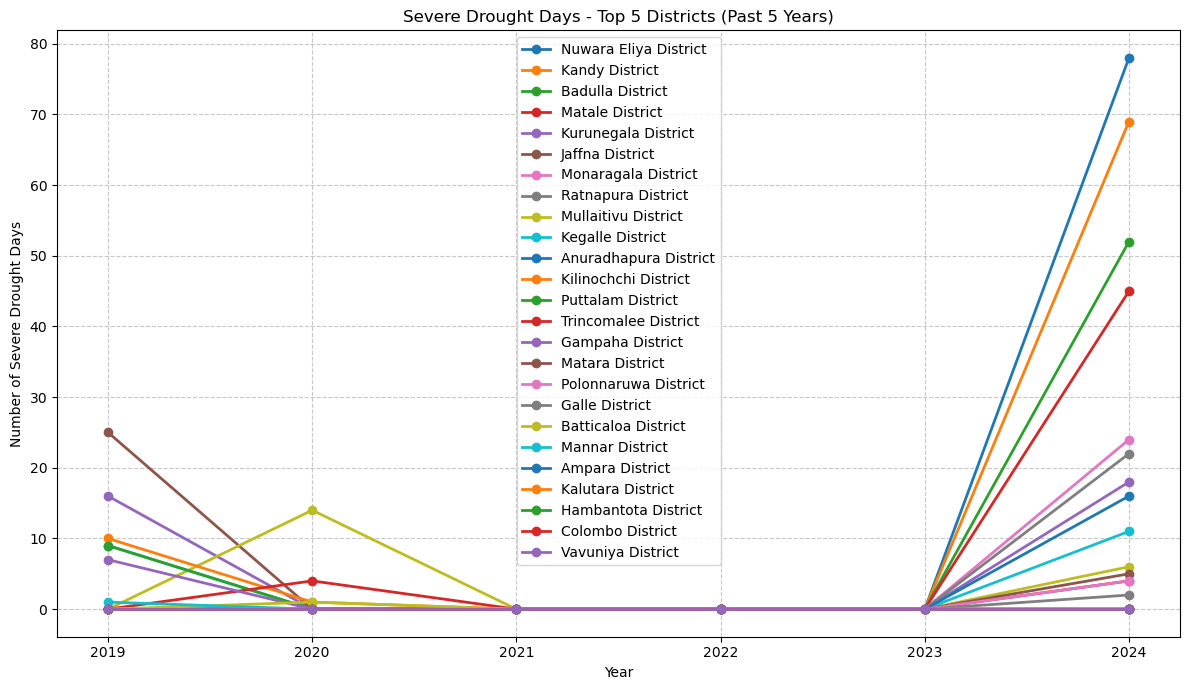

In [36]:
yearly_columns = [col for col in drought_pivot.columns if col != 'Total Drought Days']

# Plot
plt.figure(figsize=(12, 7))
for idx, row in result_table.iterrows():
    district = row['District']
    values = [row[col] for col in yearly_columns]
    plt.plot(yearly_columns, values, marker='o', linewidth=2, label=district)

plt.title('Severe Drought Days - Top 5 Districts (Past 5 Years)')
plt.xlabel('Year')
plt.ylabel('Number of Severe Drought Days')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## Map the number of extreme drought events

In [38]:
# Create a GeoDataFrame from the original data
# Convert geometry field from GeoJSON to Shapely
if isinstance(df["geometry"].iloc[0], str):
    df["geometry"] = df["geometry"].apply(json.loads)
df["geometry"] = df["geometry"].apply(shape)

# First, let's extract unique regions with their geometries
# Group by region and take the first geometry for each region
region_geo = df[['hex_id', 'region', 'geometry']].drop_duplicates(subset=['hex_id'])
gdf = gpd.GeoDataFrame(region_geo, geometry="geometry", crs="EPSG:4326")

drought_gdf = gdf.merge(result_table, left_on='region', right_on='District')
drought_gdf = drought_gdf.drop(columns=['District'])

# Prepare tooltip columns
yearly_columns = [col for col in drought_gdf.columns if col.isdigit() or col == 'Total Drought Days']
tooltip_columns = ['region'] + yearly_columns

# Create the map
m = drought_gdf.explore(
    column='Total Drought Days',
    tooltip=tooltip_columns,
    cmap="OrRd",
    legend=True,
    scheme="quantiles",
    legend_kwds=dict(colorbar=True, caption=f"Drought Days ({column_to_display})", interval=False),
    style_kwds=dict(weight=0.5, fillOpacity=0.8),
    name="Drought Risk by District"
)

# Add district boundaries as a separate layer
districts_layer = drought_gdf.explore(
    m=m,
    style_kwds=dict(color="black", weight=0.25, opacity=0.5, fillOpacity=0),
    name="District Boundaries",
    tooltip=tooltip_columns
)

# Display the map
display(m)